# Jan 13th, 2022 (topo dist, best density)

**Motivation**: Applied to $128*0$ and $256*0$  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from analysis.portrait import *
from sklearn.manifold import TSNE, MDS

## 128*0

In [3]:
mice = Mice((128, 0, 100))

### Bold-lite

In [4]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-lite', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(114, 174, 174)

In [5]:
densities = density_space(start=0.20, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [6]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 1.08 s, sys: 2.21 s, total: 3.29 s
Wall time: 17.2 s


In [7]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [8]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 1.17 s, sys: 2.22 s, total: 3.4 s
Wall time: 11.2 s


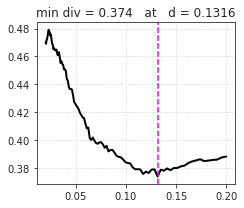

In [9]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [10]:
dfs = prepare_divergence_dfs(div, densities, ids)

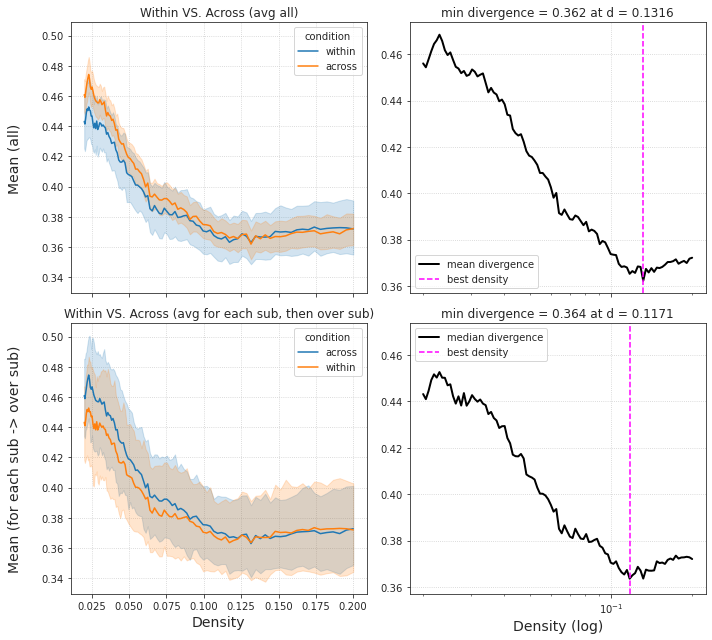

In [11]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [12]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(23, 0.11714041636113333)

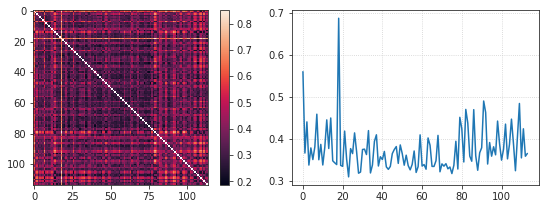

In [13]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [14]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC02_ses-2_run-5',
    'sub-SLC01_ses-1_run-1',
    'sub-SLC09_ses-1_run-1',
    'sub-SLC10_ses-2_run-7',
    'sub-SLC08_ses-1_run-5',
    'sub-SLC08_ses-2_run-7',
    'sub-SLC09_ses-1_run-3',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC07_ses-3_run-5',
    'sub-SLC02_ses-1_run-5'
]

In [15]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

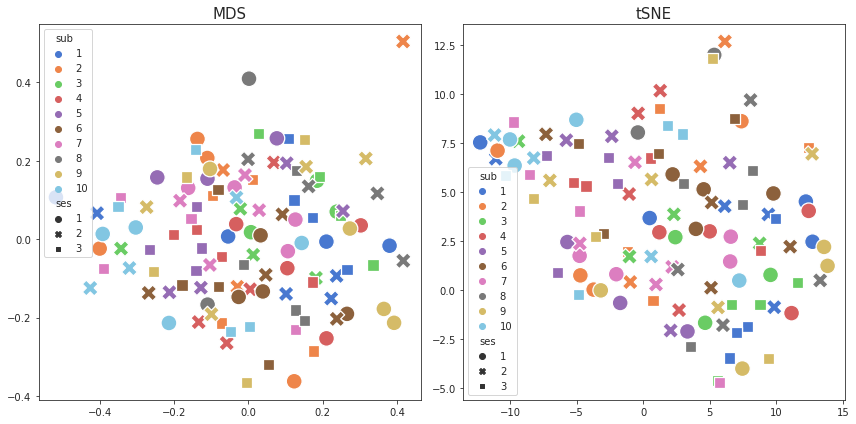

In [16]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

### Ca2

In [17]:
adjacencies, dirs = collect_adjacencies(mice, 'ca2', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(118, 174, 174)

In [18]:
densities = density_space(start=0.20, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [19]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 1.24 s, sys: 2.55 s, total: 3.79 s
Wall time: 15.3 s


In [20]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [21]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 1.12 s, sys: 2.52 s, total: 3.63 s
Wall time: 11.4 s


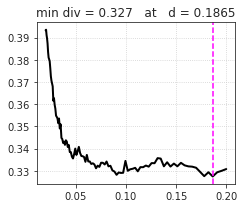

In [22]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [23]:
dfs = prepare_divergence_dfs(div, densities, ids)

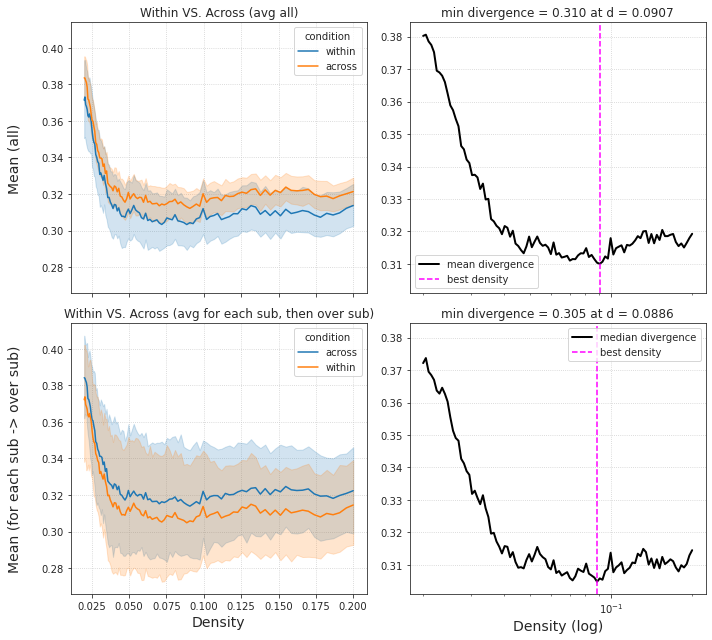

In [24]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [25]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(35, 0.08861242915167761)

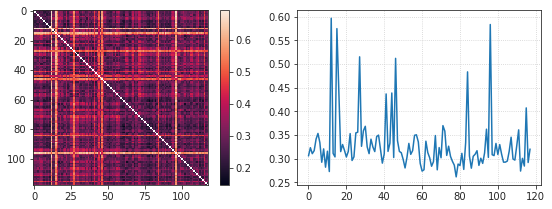

In [26]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [27]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC02_ses-1_run-1',
    'sub-SLC09_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC04_ses-2_run-5',
    'sub-SLC10_ses-3_run-3'
]

In [28]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

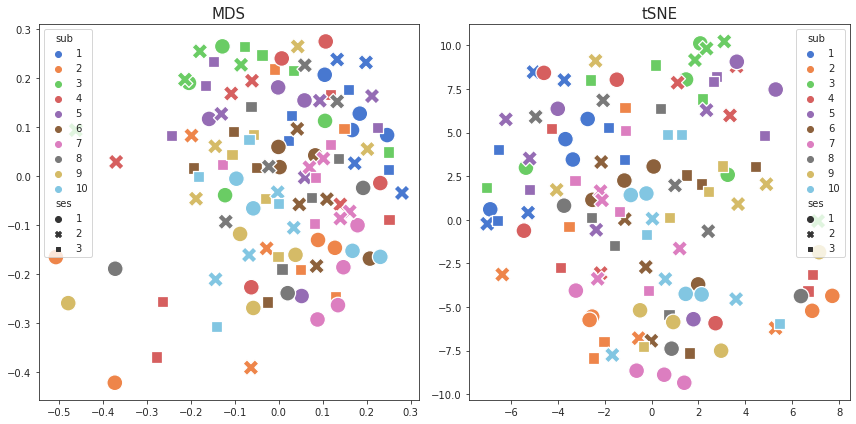

In [29]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

### BOLD-Ctx

In [31]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-ctx', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(114, 734, 734)

In [32]:
densities = density_space(start=0.50, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [33]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 2.55 s, sys: 3.78 s, total: 6.33 s
Wall time: 12min 53s


In [34]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [35]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 1.81 s, sys: 3.57 s, total: 5.38 s
Wall time: 23.2 s


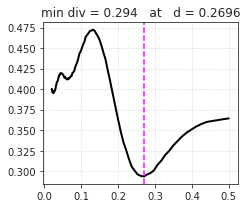

In [36]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [37]:
dfs = prepare_divergence_dfs(div, densities, ids)

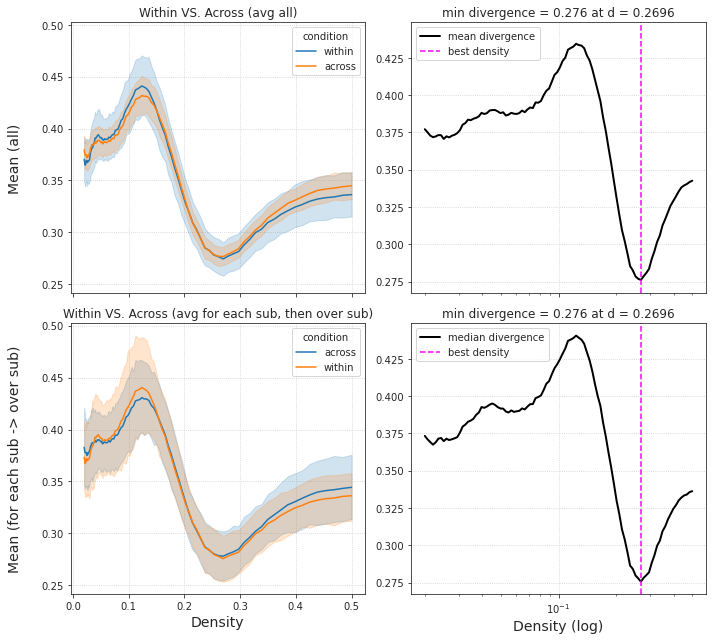

In [38]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [39]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(19, 0.269574300846587)

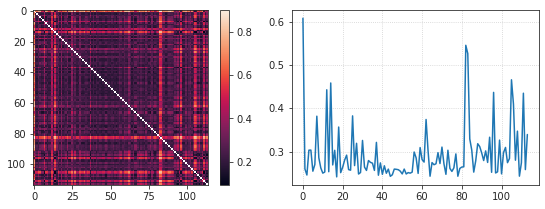

In [40]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [41]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC01_ses-1_run-1',
    'sub-SLC08_ses-1_run-5',
    'sub-SLC08_ses-2_run-1',
    'sub-SLC10_ses-1_run-5',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC09_ses-2_run-3',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC10_ses-1_run-7',
    'sub-SLC03_ses-1_run-6'
]

In [42]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

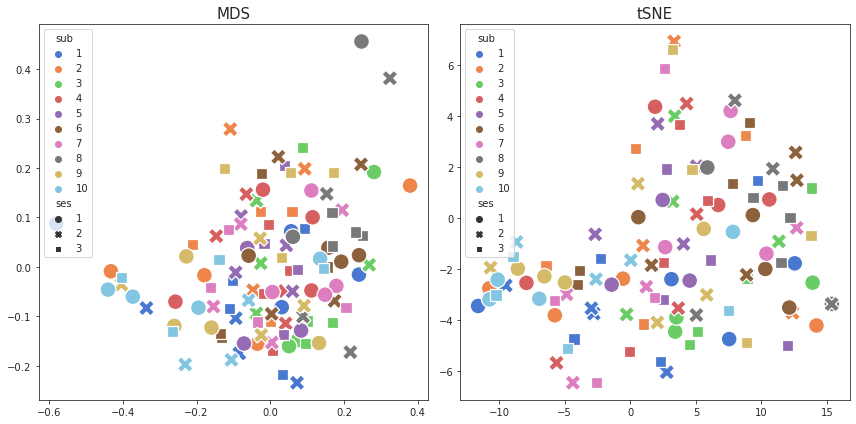

In [43]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

### BOLD

In [44]:
adjacencies, dirs = collect_adjacencies(mice, 'bold', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(114, 1040, 1040)

In [45]:
densities = density_space(start=0.50, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [46]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 2.88 s, sys: 5.11 s, total: 7.99 s
Wall time: 30min 47s


In [47]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [48]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 2.11 s, sys: 5.11 s, total: 7.21 s
Wall time: 30.3 s


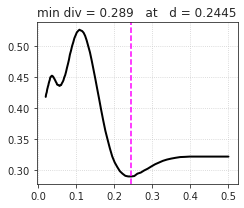

In [49]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [50]:
dfs = prepare_divergence_dfs(div, densities, ids)

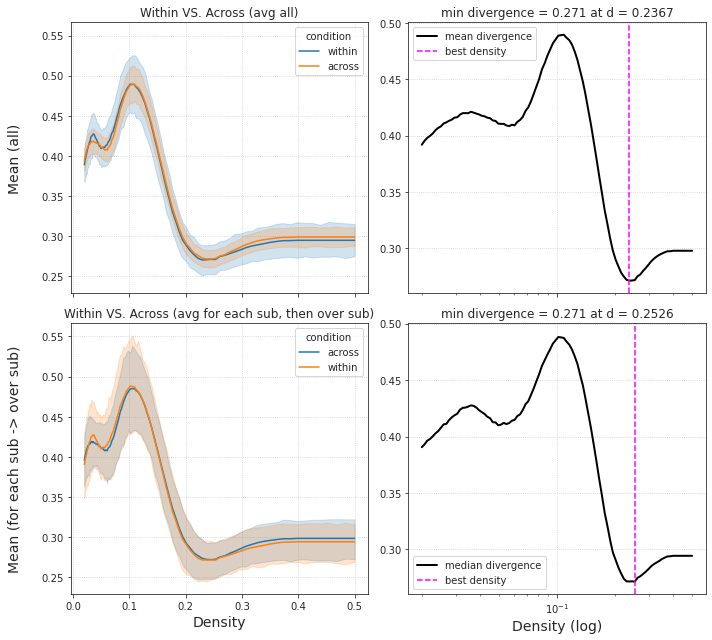

In [51]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [52]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(21, 0.2526022852489645)

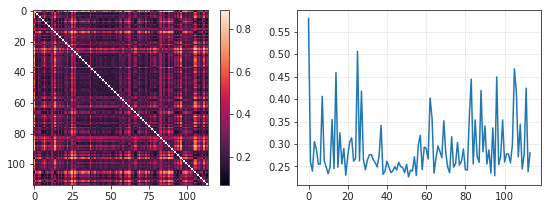

In [53]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [54]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC01_ses-1_run-1',
    'sub-SLC03_ses-1_run-6',
    'sub-SLC10_ses-1_run-5',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC09_ses-2_run-3',
    'sub-SLC08_ses-2_run-1',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC08_ses-3_run-3',
    'sub-SLC03_ses-2_run-3',
    'sub-SLC10_ses-1_run-7'
]

In [55]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

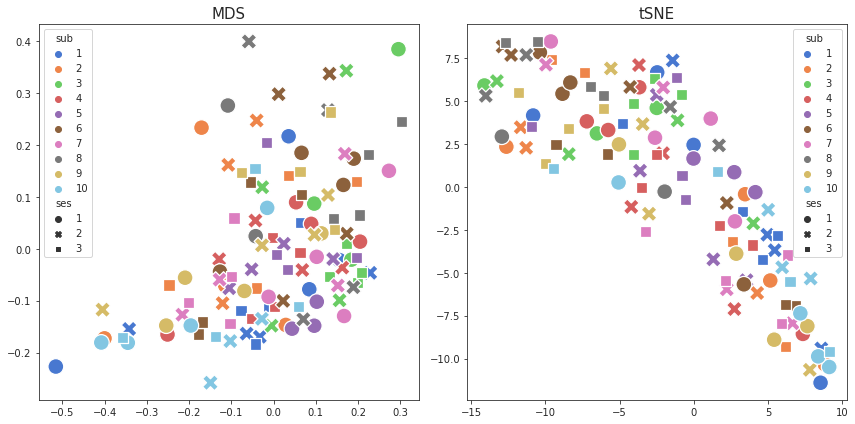

In [56]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

## 256*0

In [3]:
mice = Mice((256, 0, 100))

### Bold-lite

In [58]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-lite', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(114, 312, 312)

In [59]:
densities = density_space(start=0.20, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [60]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 2.17 s, sys: 6.5 s, total: 8.67 s
Wall time: 1min 1s


In [61]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [62]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 1.72 s, sys: 4.78 s, total: 6.5 s
Wall time: 18.4 s


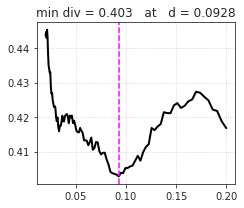

In [63]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [64]:
dfs = prepare_divergence_dfs(div, densities, ids)

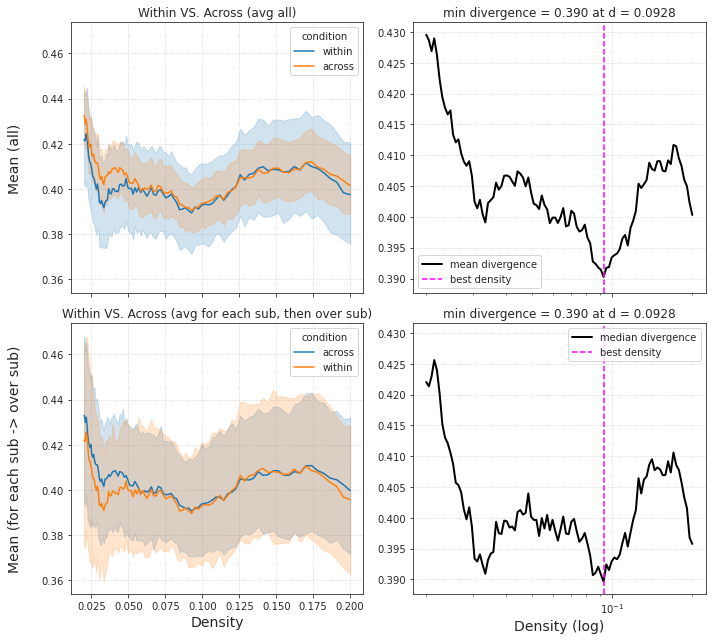

In [65]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [66]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(33, 0.09283177667225556)

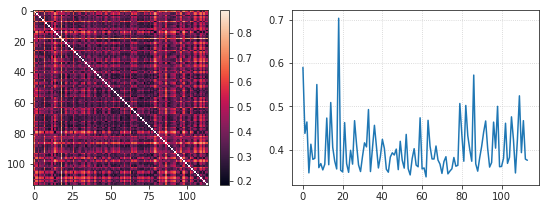

In [67]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [68]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC02_ses-2_run-5',
    'sub-SLC01_ses-1_run-1',
    'sub-SLC08_ses-2_run-7',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC10_ses-2_run-7',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC07_ses-3_run-5',
    'sub-SLC08_ses-1_run-5',
    'sub-SLC09_ses-2_run-7',
    'sub-SLC03_ses-3_run-7'
]

In [69]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

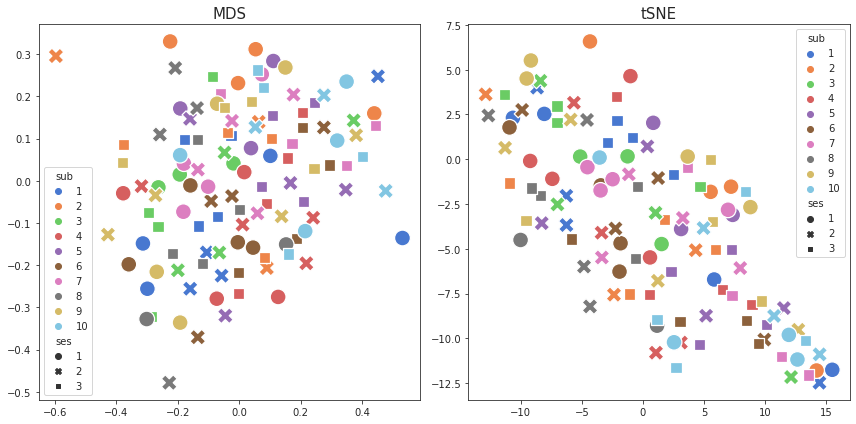

In [70]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

### Ca2

In [71]:
adjacencies, dirs = collect_adjacencies(mice, 'ca2', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(118, 318, 318)

In [72]:
densities = density_space(start=0.20, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [73]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 1.67 s, sys: 4.89 s, total: 6.56 s
Wall time: 49.1 s


In [74]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [75]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 1.59 s, sys: 4.85 s, total: 6.44 s
Wall time: 17 s


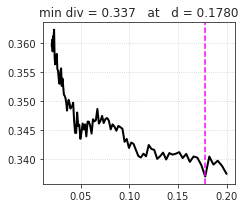

In [76]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [77]:
dfs = prepare_divergence_dfs(div, densities, ids)

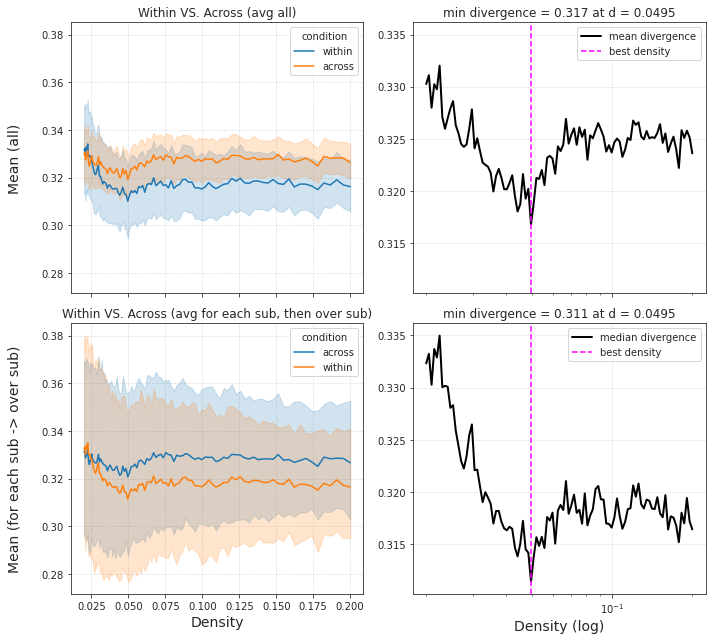

In [78]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [79]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(60, 0.049541527119834235)

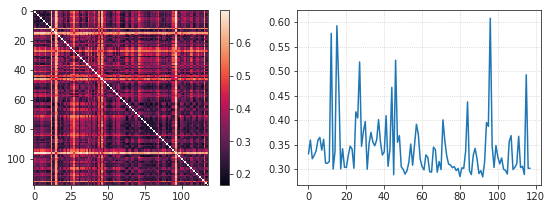

In [80]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [81]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC09_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC03_ses-1_run-4'
]

In [82]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

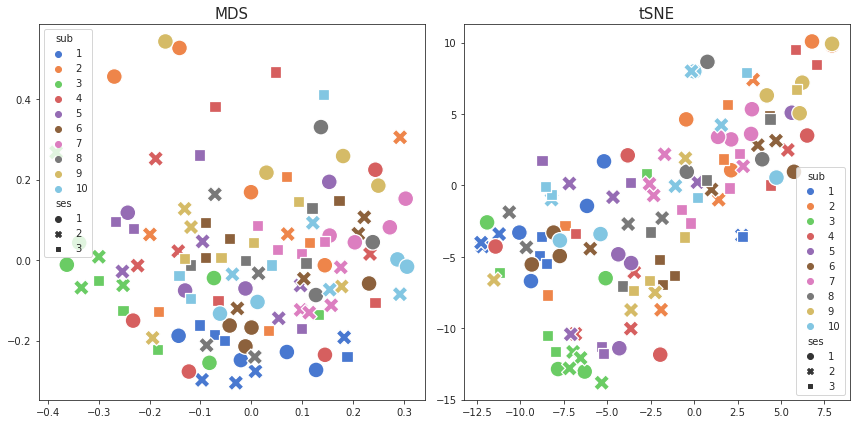

In [83]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

### BOLD-Ctx

In [4]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-ctx', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(114, 1312, 1312)

In [5]:
densities = density_space(start=0.50, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [6]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 3.17 s, sys: 4.53 s, total: 7.7 s
Wall time: 1h 2min 34s


In [7]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [8]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 2.54 s, sys: 3.66 s, total: 6.2 s
Wall time: 32.1 s


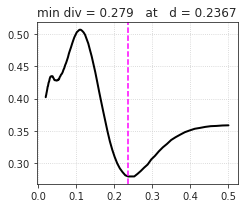

In [9]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [10]:
dfs = prepare_divergence_dfs(div, densities, ids)

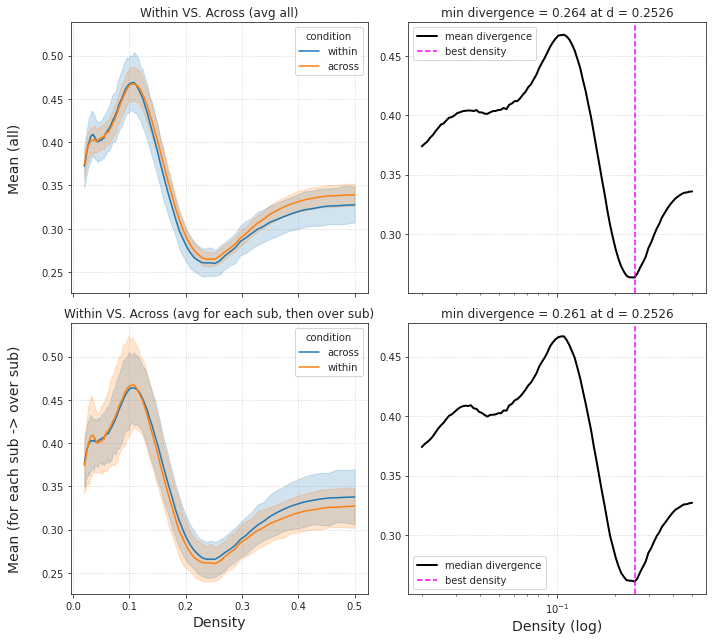

In [11]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [12]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(21, 0.2526022852489645)

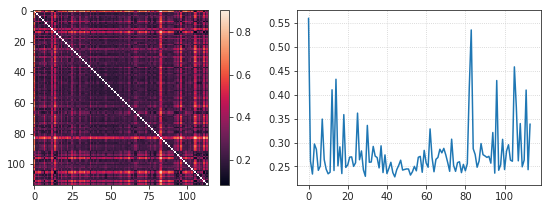

In [13]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [14]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC01_ses-1_run-1',
    'sub-SLC08_ses-2_run-1',
    'sub-SLC10_ses-1_run-5',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC09_ses-2_run-3',
    'sub-SLC08_ses-1_run-5',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC10_ses-1_run-7',
    'sub-SLC03_ses-1_run-6'
]

In [15]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

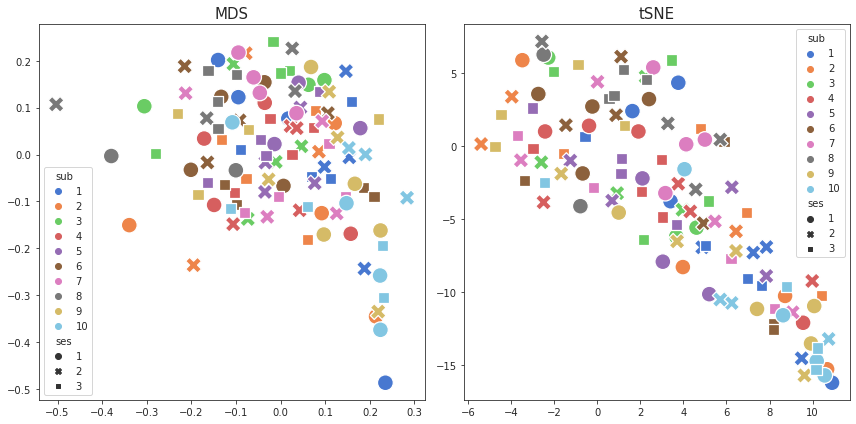

In [16]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

### BOLD

In [17]:
adjacencies, dirs = collect_adjacencies(mice, 'bold', 'rest')
ids = mice.get_condition_ids(dirs)
adjacencies.shape

(114, 1616, 1616)

In [18]:
densities = density_space(start=0.50, stop=0.02, num=100, log=True)
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [19]:
%%time

calculate_portraits_parallel(adjacencies, thresholds, dirs)

CPU times: user 4.14 s, sys: 7.75 s, total: 11.9 s
Wall time: 1h 46min 18s


In [20]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [21]:
%%time

div = calculate_portrait_divergece_parallel(portraits, densities)

CPU times: user 3.9 s, sys: 6.45 s, total: 10.4 s
Wall time: 44.2 s


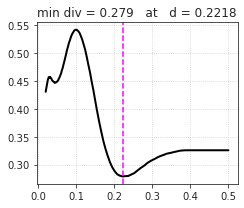

In [22]:
div_global_avg = bn.nanmean(div.reshape(len(div), -1), -1)
best_i = np.argmin(div_global_avg)
best_d = densities[best_i]
min_div = div_global_avg[best_i]

fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(densities, div_global_avg, color='k', lw=2)
ax.axvline(best_d, color='magenta', ls='--')
ax.set_title(f"min div = {min_div:0.3f}   at   d = {best_d:0.4f}")
ax.grid()
plt.show()

In [23]:
dfs = prepare_divergence_dfs(div, densities, ids)

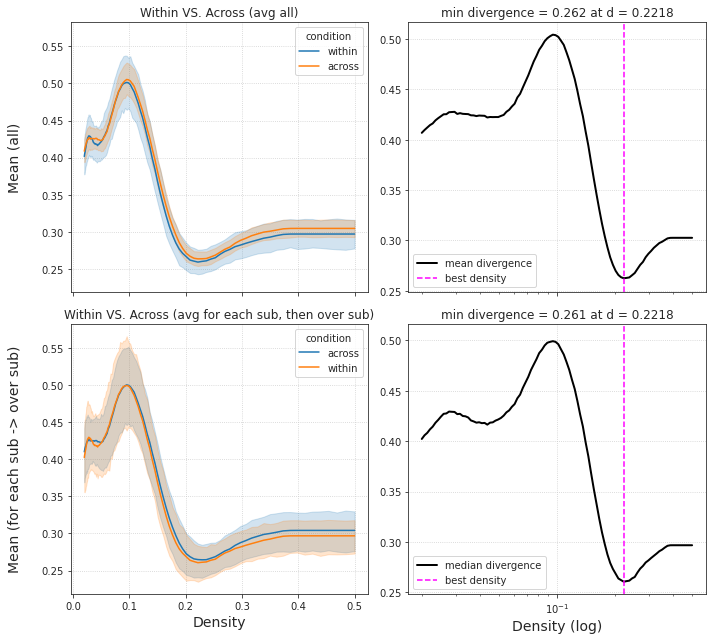

In [24]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = dfs['full'].loc[dfs['full']['condition'] == 'within']
df_avg = dfs['full'].groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['full'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = dfs['animal'].loc[dfs['animal']['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=dfs['animal'],
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

axes[1, 0].set_xlabel('Density', fontsize=14)
axes[1, 1].set_xlabel('Density (log)', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [25]:
best_di = np.where(densities == dfs['best_d'])[0].item()
best_di, densities[best_di]

(25, 0.22179658275009898)

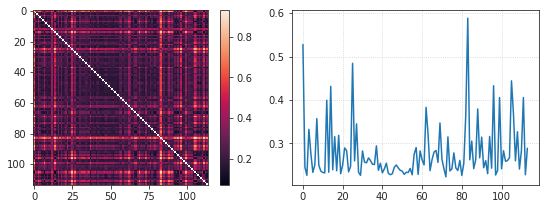

In [26]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [27]:
bad_runs = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs = [list(dirs)[i] for i in bad_runs]
bad_runs

[
    'sub-SLC08_ses-2_run-1',
    'sub-SLC01_ses-1_run-1',
    'sub-SLC03_ses-1_run-6',
    'sub-SLC10_ses-1_run-5',
    'sub-SLC09_ses-2_run-3',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC09_ses-3_run-1',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC06_ses-2_run-3'
]

In [28]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

mds = MDS(n_components=2, dissimilarity='precomputed')
x_mds = mds.fit_transform(x)

x_tsne = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)


# cat the two
x_emb = np.concatenate([x_mds, x_tsne])
labels = ['MDS'] * len(x_mds) + ['tSNE'] * len(x_tsne)


# makde df
df_emb = pd.DataFrame({
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'label': labels,
})

subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
df_emb['sub'] = subs * 2
df_emb['ses'] = sess * 2
df_emb['run'] = runs * 2

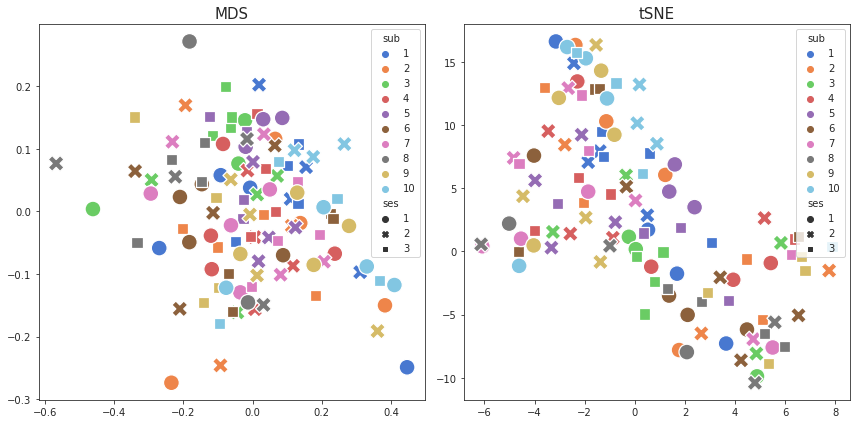

In [29]:
fig, axes = create_figure(1, 2, (12, 6))

for lbl, ax in zip(df_emb['label'].unique(), axes.flat):
    sns.scatterplot(
        data=df_emb.loc[df_emb['label'] == lbl],
        x='x',
        y='y',
        hue='sub',
        palette='muted',
        style='ses',
        alpha=1.0,
        s=250,
        ax=ax,
    )
    ax.set_title(lbl, fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()